in this project, the goal is to find a well trained deep learning model that outputs pollution factors of EF7 engine besed on load on engine and angel of CVVT camshaft and some other parameters.
for this project i used keras over Tensorflow with dense neural network.
to tune hyper parameters of network, i used kers-tuner.

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 26.3 MB/s 
     |████████████████████████████████| 1.6 MB 64.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split


physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


raw data is excel sheets provided by IPCO Test center.
we read those sheets with pandas dataframe

In [3]:
dfs = []
for i in range(0, 13, 2):
    dfs.append(pd.read_excel("/content/drive/MyDrive/IPCO/small.xlsx", sheet_name=i).iloc[3:, :])

filtering needed columns and concat all sheets to one dataframe

In [4]:
df = pd.concat(dfs)
df = df.iloc[:, [1, 2, 3, 5, 6, 7, 8, 9, 10, 18, 20, 24, 27]]
df.shape

(1640, 13)

these data contains a lot of nan, so we have to clean data and try to prepare
as much data as we can.

In [5]:
df.dropna(inplace = True)
df.shape

(684, 13)

need all features to be numeric

In [6]:
df = df.apply(pd.to_numeric)

spliting input and output data

In [7]:
X = df.iloc[:,[0, 1, 3, 4, 5]].copy()
Y = df.iloc[:,[2, 6, 7, 8, 9, 10, 11, 12]].copy()

In [8]:
X.shape

(684, 5)

normalizing input features with sklearn

In [9]:
from sklearn import preprocessing
X = X.values #returns a numpy array
X_min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = X_min_max_scaler.fit_transform(X)

normalizing output data with sklearn

In [10]:
Y = Y.values #returns a numpy array
Y_min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = Y_min_max_scaler.fit_transform(Y)

In [11]:
x_scaled.shape

(684, 5)

for evaluation of how well the model predicts, we need some data to be test data, so we split data to train and test data with test size of 0.2
for this perpose i used train_test_split function from sklearn model selection utils.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

In [13]:
X_train

array([[0.49975012, 0.82241598, 0.99878917, 0.50165274, 0.33272149],
       [0.24987506, 0.65228375, 0.251034  , 0.99837744, 0.26135501],
       [0.99950025, 0.31201929, 0.49945145, 0.99467097, 0.42683193],
       ...,
       [0.24987506, 0.82241598, 0.24855404, 0.50221649, 0.18021673],
       [0.49975012, 0.65228375, 0.74879676, 0.0060429 , 0.33793827],
       [0.        , 0.82241598, 0.24987017, 0.25199648, 0.11196355]])

in this section of code i used kers_tuner to find the best hyper parameters

In [14]:
# def model_builder(hp):
#     input = Input(shape=(X_train.shape[1]), name="Input")

#     x = Dense(256, activation="ReLU")(input)
#     x = Dropout(0.2)(x)


#     x = Dense(256, activation="ReLU")(x)
#     x = Dropout(0.2)(x)


#     x = Dense(256, activation="ReLU")(x)
#     x = Dropout(0.2)(x)

#     x = Dense(256, activation="ReLU")(x)
#     x = Dropout(0.2)(x)

#     x = Dense(256, activation="ReLU")(x)

#     # x = Dense(256, activation="ReLU")(x)


#     output = Dense(y_train.shape[1])(x)

#     model = Model(inputs=input, outputs=output)
    


#     # Tune the learning rate for the optimizer
#     # hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

#     # hp_decay = hp.Choice('decay', values=[0.99, 0.95, 0.9])

#     # opt = tf.keras.optimizers.Adam(
#     #     learning_rate=hp_learning_rate,
#     #     decay=hp_decay
#     # )

#     model.compile(optimizer="adam",
#                 loss='mse',
#                 metrics=['mse'])



#     # print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)
#     return model

removing the directory of previous attempts to find the best model hyperparameters

In [15]:
%rm -r /content/drive/MyDrive/IPCO/kat/IPCO

In [16]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mse',
                     max_epochs=100,
                     factor=16,
                     directory='/content/drive/MyDrive/IPCO/kat',
                     project_name='IPCO')

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=4)

In [18]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

Trial 10 Complete [00h 00m 04s]
val_mse: 0.0263019111007452

Best val_mse So Far: 0.02407967858016491
Total elapsed time: 00h 00m 36s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
1e-05             |0.01              |learning_rate
0.9               |0.99              |decay
7                 |7                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/7


KeyboardInterrupt: ignored

In [ ]:
# best_hps.values

In [ ]:
# best_model = tuner.get_best_models()[0]

let's build the best model with adam optimizer and mean square error as loss function

In [19]:
def model():
    input = Input(shape=(X_train.shape[1]), name="Input")

    x = Dense(256, activation="ReLU")(input)
    x = Dropout(0.2)(x)


    x = Dense(256, activation="ReLU")(x)
    x = Dropout(0.2)(x)


    x = Dense(256, activation="ReLU")(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation="ReLU")(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation="ReLU")(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation="ReLU")(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation="ReLU")(x)

    # x = Dense(256, activation="ReLU")(x)


    output = Dense(y_train.shape[1])(x)

    model = Model(inputs=input, outputs=output)
    


    # Tune the learning rate for the optimizer


    # opt = tf.keras.optimizers.Adam(
    #     learning_rate=1e-1,
    #     decay=0.99
    # )

    model.compile(optimizer="adam",
                loss='mse',
                metrics=['mse'])



    # print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

let's train the model for 1024 epochs

In [20]:
model = model()
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=1024,
                    verbose=1, validation_data=[X_test, y_test])

Epoch 1/1024
5/5 [==============================] - 1s 44ms/step - loss: 0.1317 - mse: 0.1317 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 2/1024
5/5 [==============================] - 0s 11ms/step - loss: 0.0515 - mse: 0.0515 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 3/1024
5/5 [==============================] - 0s 9ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 4/1024
5/5 [==============================] - 0s 9ms/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 5/1024
5/5 [==============================] - 0s 9ms/step - loss: 0.0271 - mse: 0.0271 - val_loss: 0.0245 - val_mse: 0.0245
Epoch 6/1024
5/5 [==============================] - 0s 9ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 7/1024
5/5 [==============================] - 0s 13ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 8/1024
5/5 [==============================] - 0s 9ms/step - loss: 0.0224 - mse: 0

ploting the training history of the model is a good way to see how well it was gone

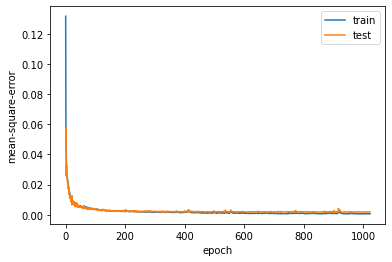

In [21]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend(["train", "test"])
plt.xlabel('epoch')
plt.ylabel('mean-square-error')
plt.savefig("model_performance.jpg")
plt.show()

lets predict with model and evaluate the performance

In [23]:
pred = model.predict(X_test[50:51])
# pred

In [ ]:
# y_test[50:51]

In [24]:
Y_min_max_scaler.inverse_transform(pred)

array([[-2.3763181e+03,  8.8695981e-02,  1.7584779e+00,  9.4050491e-01,
         8.3736896e+02,  8.8518652e+02, -4.0012320e+02,  7.5683929e+01]],
      dtype=float32)

In [25]:
Y_min_max_scaler.inverse_transform(y_test[50:51])

array([[ 2.78700000e+02,  8.53514957e-02,  1.25648504e+00,
         9.56643926e-01,  8.63559391e+02,  8.10408152e+02,
        -4.76521394e+02,  7.59739744e+01]])